In [2]:
import numpy as np
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import dem_functions as df
import bikeability_functions as bf

import gurobipy as gp
from gurobipy import GRB
import contextily as cx
import yan_helper_functions as yhf

In [3]:
def calc_opt_metrics(G, dem_SF, total_length_added, penalty, num_cc) -> pd.DataFrame:
    betas = np.linspace(0.01, 10, 200)
    curves_SF = bf.compute_bikeability_curves(G, G.nodes(), dest="all")
    user_dict_SF = bf.network_wide_bikeability_curve(betas, curves_SF)

    keys = [
        "frac_pop_nonwhite",
        "frac_below_poverty",
        "median_hh_income",
        "frac_no_car",
    ]
    quant_of_int = df.all_quants(keys, dem_SF)
    nonwhite_low, nonwhite_high = yhf.quint_curves(
        G, quant_of_int, "frac_pop_nonwhite")
    poverty_low, poverty_high = yhf.quint_curves(
        G, quant_of_int, "frac_below_poverty")
    income_low, income_high = yhf.quint_curves(
        G, quant_of_int, "median_hh_income")
    carless_low, carless_high = yhf.quint_curves(
        G, quant_of_int, "frac_no_car")

    new_row = {
        "length_added_bikelanes": total_length_added,
        "lambda": penalty,
        "num_cc": num_cc,
        "overall_score": bf.calc_elbow(user_dict_SF),
        "nonwhite_high": bf.calc_elbow(nonwhite_high),
        "nonwhite_low": bf.calc_elbow(nonwhite_low),
        "poverty_high": bf.calc_elbow(poverty_high),
        "poverty_low": bf.calc_elbow(poverty_low),
        "income_high": bf.calc_elbow(income_high),
        "income_low": bf.calc_elbow(income_low),
        "carless_high": bf.calc_elbow(carless_high),
        "carless_low": bf.calc_elbow(carless_low),
    }

    return pd.DataFrame([new_row])

In [4]:
def dist_decay(x):
    return np.e ** (-x / 10000)

In [6]:
def calculate_optimization_data(key):
    new_networks = []

    dataframe = pd.DataFrame(
        columns=[
            "length_added_bikelanes",
            "lambda",
            "num_cc",
            "overall_score",
            "nonwhite_high",
            "nonwhite_low",
            "poverty_high",
            "poverty_low",
            "income_high",
            "income_low",
            "carless_high",
            "carless_low",
        ]
    )

    # np.linspace(1000, 10000, 5)

    for penalty in np.linspace(1000, 10000, 5):
        print("PENALTY:", penalty)
        # data
        G, dem = yhf.load_sf_data()
        G_new = nx.DiGraph()
        G_new.add_nodes_from(G.nodes(data=True))

        # lowest quintile nodes
        # keys = ['frac_pop_nonwhite','frac_below_poverty','median_hh_income','frac_no_car']
        keys = [key]
        low_nodes = df.all_quants(keys, dem)[key][0]

        # calculate centroid of lower quintile
        x, y = [], []

        for node in low_nodes:
            x.append(G.nodes(data=True)[node]["x"])
            y.append(G.nodes(data=True)[node]["y"])

        centroid_x = np.mean(x)
        centroid_y = np.mean(y)

        sum = 0

        # calc t_vector
        term_vals = {}

        for node in G.nodes:
            if node in low_nodes:
                continue

            # distance to centroid
            dist = np.linalg.norm(
                [centroid_x - G.nodes[node]["x"], centroid_y - G.nodes[node]["y"]],
                ord=2,
            )

            term_vals[node] = dist_decay(dist)
            sum += dist_decay(dist)

        for node in low_nodes:
            term_vals[node] = -sum / len(low_nodes)

        nodes = list(term_vals.keys())
        t_vector = np.array(list(term_vals.values()))

        n_nodes = len(G.nodes)

        B = np.zeros((n_nodes, n_nodes))
        R = np.zeros((n_nodes, n_nodes))

        for edge in G.edges(data=True):
            dist_vec = edge[2]["distance"]
            start_node = nodes.index(edge[0])
            end_node = nodes.index(edge[1])

            if not np.isnan(dist_vec[0]):
                B[start_node][end_node] = dist_vec[0]

            if not np.isnan(np.nanmin(dist_vec[1:])):
                R[start_node][end_node] = np.nanmin(dist_vec[1:])

        m = gp.Model()
        m.Params.LogToConsole = 0
        W = m.addMVar(
            shape=(n_nodes, n_nodes),
            lb=0.0,
            ub=float("inf"),
            vtype=GRB.CONTINUOUS,
            name="flow weights",
        )
        X = m.addMVar(shape=(n_nodes, n_nodes), vtype=GRB.BINARY, name="is_upgraded")
        err = m.addMVar(
            shape=n_nodes,
            lb=-float("inf"),
            ub=float("inf"),
            vtype=GRB.CONTINUOUS,
            name="err",
        )
        n = m.addVar(lb=0.0, ub=float("inf"), vtype=GRB.CONTINUOUS, name="norm")

        BUDGET = 40 * 1000

        m.addConstr((X * R).sum() == BUDGET, name="budget")
        m.addConstr(W.sum(axis=0) == W.sum(axis=1) + t_vector + err)

        m.addGenConstrNorm(n, err, 2.0, "normconstr")

        D = (1 - X) * B + X * R

        m.setObjective((W * D).sum() + penalty * n, GRB.MINIMIZE)
        m.addConstr(D * 1e100 >= W)
        m.optimize()

        # upgrade network
        result = X.X
        length_upgraded = 0

        for i in range(result.shape[0]):
            for j in range(result.shape[0]):
                if result[i][j] == 1:
                    start_node = nodes[i]
                    end_node = nodes[j]
                    G[start_node][end_node][0]["distance"][0] = R[i][j]
                    length_upgraded += R[i][j]
                    # print(start_node, end_node, G[start_node][end_node][0]['distance'], R[i][j])
                    G_new.add_edge(start_node, end_node)

        G_bikelanes = nx.DiGraph()  # graph of all bikelanes
        G_bikelanes.add_nodes_from(G.nodes(data=True))

        # create bikelane and potential bikelane networks
        for start_node, end_node, data in G.edges(data=True):
            if not np.isnan(data["distance"][0]):
                G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

        num_cc = nx.number_strongly_connected_components(G_bikelanes)

        row = calc_opt_metrics(G, dem, 40, penalty, num_cc)
        # print(row)

        dataframe = pd.concat([dataframe, row])
        new_networks.append(G_new)

    return dataframe, new_networks

In [7]:
# 3 hours
keys = [
    "median_hh_income",
]

data, graphs = calculate_optimization_data("median_hh_income")
data.to_csv("data/" + keys[0] + "_optim.csv")

PENALTY: 1000.0
Matched: San Francisco,CA to San Francisco city within layer Incorporated Places
Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-28


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))
C:\Users\ckaz3\AppData\Local\Temp\ipykernel_274884\2663747136.py:146: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataframe = pd.concat([dataframe, row])


PENALTY: 3250.0
Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


PENALTY: 5500.0
Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


PENALTY: 7750.0
Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


PENALTY: 10000.0
Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [11]:
data = pd.read_csv("data/median_hh_income_optim.csv")
data = data.drop("Unnamed: 0", axis=1)

data["nonwhite_ratio"] = data["nonwhite_low"] / data["nonwhite_high"]
data["poverty_ratio"] = data["poverty_low"] / data["poverty_high"]
data["income_ratio"] = data["income_high"] / data["income_low"]
data["carless_ratio"] = data["carless_low"] / data["carless_high"]

data = data[
    [
        "length_added_bikelanes",
        "lambda",
        "num_cc",
        "overall_score",
        "nonwhite_ratio",
        "poverty_ratio",
        "income_ratio",
        "carless_ratio",
    ]
]

data["overall_score_pc"] = (data["overall_score"] - 3.48) / 3.48 * 100
data["poverty_ratio_pc"] = (data["poverty_ratio"] - 1.85) / 1.85 * 100
data["income_ratio_pc"] = (data["income_ratio"] - 2.14) / 2.14 * 100
data["carless_ratio_pc"] = (data["carless_ratio"] - 1.97) / 1.97 * 100
data["nonwhite_ratio_pc"] = (data["nonwhite_ratio"] - 1.13) / 1.13 * 100
data = data.reindex(sorted(data.columns), axis=1)
data

,carless_ratio,carless_ratio_pc,income_ratio,income_ratio_pc,lambda,length_added_bikelanes,nonwhite_ratio,nonwhite_ratio_pc,num_cc,overall_score,overall_score_pc,poverty_ratio,poverty_ratio_pc
0,2.069385,5.044920,2.046663,-4.361521,1000.0,40,1.069354,-5.366924,85,3.952132,13.567024,1.796386,-2.898059
1,1.715101,-12.939055,2.004749,-6.320146,3250.0,40,1.069291,-5.372441,85,4.163513,19.641175,1.702739,-7.960081
2,1.508540,-23.424368,1.659967,-22.431451,5500.0,40,1.004466,-11.109182,83,4.175077,19.973490,1.372785,-25.795398
3,1.594440,-19.063971,1.729785,-19.168914,7750.0,40,0.960683,-14.983777,88,4.099978,17.815459,1.499483,-18.946851
4,1.602756,-18.641832,1.720371,-19.608825,10000.0,40,0.928636,-17.819821,85,4.265748,22.578966,1.465074,-20.806830


Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\equitable-cycling-networks\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


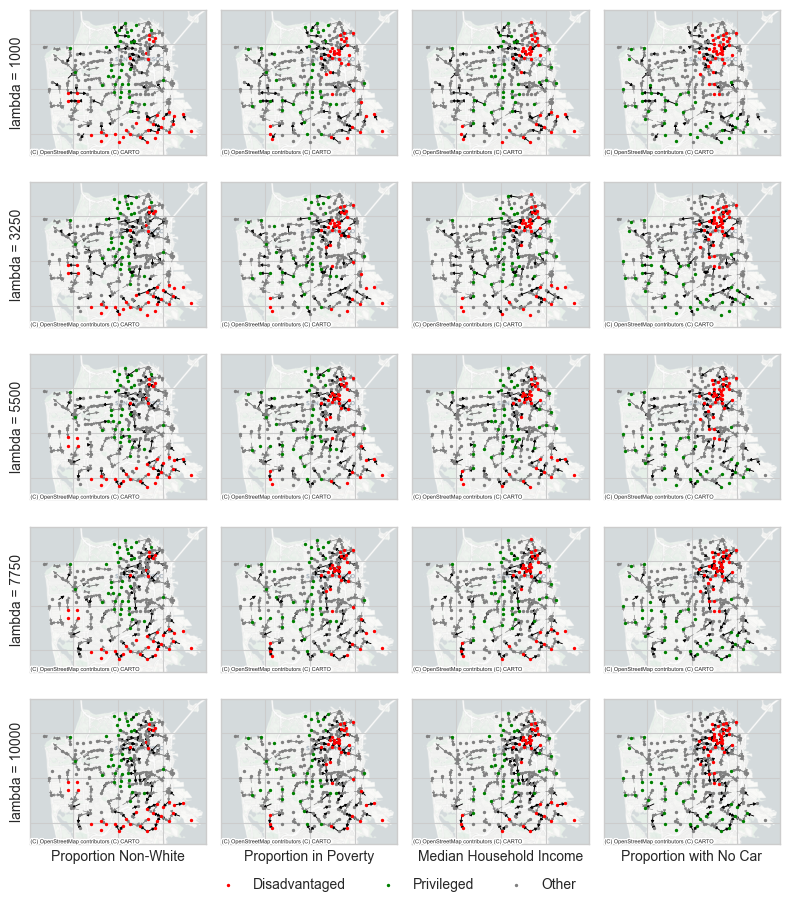

In [47]:
G_SF, dem_SF = yhf.load_sf_data()
lambdas = [1000, 3250, 5500, 7750, 10000]
keys = ["frac_pop_nonwhite", "frac_below_poverty", "median_hh_income", "frac_no_car"]

plt.style.use("seaborn-v0_8-whitegrid")
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(8, 9), sharex=True, sharey=True)

# graph of all bikelanes
G_bikelanes = nx.DiGraph()

# create bikelane and potential bikelane networks
for start_node, end_node, data in G_SF.edges(data=True):
    if not np.isnan(data["distance"][0]):
        G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

for j, key in enumerate(keys):
    if key in ["median_hh_income"]:
        dis_nodes, priv_nodes = df.all_quants([key], dem_SF)[key]
    else:
        priv_nodes, dis_nodes = df.all_quants([key], dem_SF)[key]
    other_nodes = []

    for node in G.nodes:
        if node not in dis_nodes and node not in priv_nodes:
            other_nodes.append(node)

    coords = [nx.get_node_attributes(G_SF, "x"), nx.get_node_attributes(G_SF, "y")]
    node_pos = {}

    for k in coords[0].keys():
        node_pos[k] = tuple(d[k] for d in coords)
    for i, G_new in enumerate(graphs):
        nx.draw_networkx_edges(
            G_new,
            pos=node_pos,
            arrowsize=4.4,
            width=0.66,
            ax=axs[i][j],
            label="New Bike Lanes",
        )
        nx.draw_networkx_edges(
            G_bikelanes,
            edge_color="gray",
            pos=node_pos,
            arrowsize=4.4,
            width=0.44,
            ax=axs[i][j],
            label="Existing Bike Lanes",
        )
        nx.draw_networkx_nodes(
            G_SF,
            pos=node_pos,
            ax=axs[i][j],
            nodelist=dis_nodes,
            node_color="red",
            node_size=2,
            label="Privileged",
        )
        nx.draw_networkx_nodes(
            G_SF,
            pos=node_pos,
            ax=axs[i][j],
            nodelist=priv_nodes,
            node_color="green",
            node_size=2,
            label="Disadvantaged",
        )
        nx.draw_networkx_nodes(
            G_SF,
            pos=node_pos,
            ax=axs[i][j],
            nodelist=other_nodes,
            node_color="gray",
            node_size=2,
            label="Other",
        )
        cx.add_basemap(
            ax=axs[i][j], source=cx.providers.CartoDB.Positron, attribution_size=4
        )

lambdas = [1000, 3250, 5500, 7750, 10000]
keys = [
    "Proportion Non-White",
    "Proportion in Poverty",
    "Median Household Income",
    "Proportion with No Car",
]

for i, key in enumerate(keys):
    axs[4][i].set_xlabel(key)

for i, alg in enumerate(lambdas):
    axs[i][0].set_ylabel("lambda = " + str(alg))

handles, labels = axs[0][0].get_legend_handles_labels()
unique_labels = ["Disadvantaged", "Privileged", "Other"]
unique_handles = [
    handle for handle, label in zip(handles, labels) if label in unique_labels
]
fig.legend(
    handles=unique_handles,
    labels=unique_labels,
    loc="center",
    bbox_to_anchor=(0.5, 0),
    ncol=3,
)
plt.tight_layout()
plt.savefig("figures/new_alg_maps.png")

In [ ]:
import pickle

with open("new_alg_graph_list", "wb") as fp:
    pickle.dump(graphs, fp)

In [ ]:
with open("new_alg_graph_list", "rb") as fp:
    b = pickle.load(fp)